Importing numpy and pandas

In [ ]:
import numpy as np
import pandas as pd

Importing more utilites

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

# Part 1 : Loading training and test data



*   Variables to hold paths of training features, training labels, and test features respectively



In [ ]:
f_tr_feat = './training_features.csv'
f_tr_lab = './training_labels.csv'
f_te_feat = './testing_features.csv'



*   Reading files as Dataframes



In [ ]:
train_feats = pd.read_csv(f_tr_feat, parse_dates=True)
train_labels = pd.read_csv(f_tr_lab)
test_feats = pd.read_csv(f_te_feat, parse_dates=True)

Let us examine the dataframes to make sure they have been read properly.

In [ ]:
# train_feats.head()

In [ ]:
# train_feats.describe()

In [ ]:
# train_labels.head()

In [ ]:
# test_feats.head()

In [ ]:
# test_feats.describe()

In summary, there are

In [ ]:
print(f"{train_feats.shape[0]} training data")
print(f"{train_feats.shape[1]} original features")
print(f"{test_feats.shape[0]} test data")

59400 training data
40 original features
14850 test data


# Part 2 : Analyzing Data

First, let us see how many waterpoints are there in each category in the training set. 

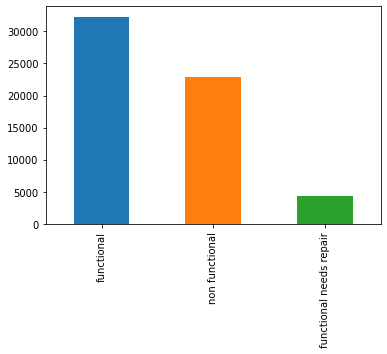

In [ ]:
colors = sns.color_palette()[:3]
train_labels.status_group.value_counts().plot.bar(color=colors)

Seems like the most of them are 'functional'. Least are 'functional needs repair'.

Now let us analyze about the features in the dataset in more detail. As you know, the dataset is about waterpoints in Tanzania.

Following are the feature column names:

In [ ]:
train_feats.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

Now let us see what are the data types of these feature columns.

In [ ]:
train_feats.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

It seems like many features are categorical as their data type is ```object```.

# Part 3: Data Preprocessing

Let us check in which columns are there missing values. Note that missing values can be null, and in some cases 0 might represent missing data as well. What we will mainly do here is to fit a `SimpleImputer` from data in training set, and apply transforms on the train and test sets. Before starting off, let us take copies of the training and test sets.

In [ ]:
train_copy = train_feats.copy()
test_copy = test_feats.copy()
train_copy.shape, test_copy.shape

((59400, 40), (14850, 40))

First let us consider null values. Following are the columns which have null values in the training set.

In [ ]:
cols_with_null = train_copy.columns[train_copy.isna().any()].tolist()
cols_with_null

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

Before moving further, let us check if there are columns with null values in the test set, which are not in the above list.

In [ ]:
extra_cols_with_null = [x for x in test_copy.columns[train_copy.isna().any()].tolist() if x not in cols_with_null]

extra_cols_with_null

[]

Well, that is good to see. It means that we have to deal with the same columns in both sets in this case.

Let us first see some stats about these columns in the train set.

In [ ]:
train_copy[cols_with_null].describe()

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
count,55765,55745,59029,56066,55523,31234,56344
unique,1897,2145,19287,2,12,2696,2
top,Government Of Tanzania,DWE,Madukani,True,VWC,K,True
freq,9084,17402,508,51011,36793,682,38852


Since all the above columns are categorical, a better approach I think is to impute missing values with the most frequent value in the corresponding column. Let us use one `SimpleImputer` for this.

In [ ]:
# Define the imputer
imp_1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Fit and transform on train set
train_copy[cols_with_null] = imp_1.fit_transform(train_copy[cols_with_null])

# Transform the test set
test_copy[cols_with_null] = imp_1.transform(test_copy[cols_with_null])

Now let us check how the dataset looks like after imputing null values.

In [ ]:
train_copy[cols_with_null].describe()

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
count,59400,59400,59400,59400,59400,59400,59400
unique,1897,2145,19287,2,12,2696,2
top,Government Of Tanzania,DWE,Madukani,True,VWC,K,True
freq,12719,21057,879,54345,40670,28848,41908


In [ ]:
test_copy[cols_with_null].describe()

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
count,14850,14850,14850,14850,14850,14850,14850
unique,980,1091,8443,2,11,1789,2
top,Government Of Tanzania,DWE,Madukani,True,VWC,K,True
freq,3084,5226,220,13559,10093,7268,10491


All seems good! As a quick check, since `public_meeting` and `permit` are supposed to be `bool` fields, let us make sure now they are so.

In [ ]:
print("Train ---\n", train_copy[['public_meeting', 'permit']].dtypes, sep="")
print("\nTest ---\n", test_copy[['public_meeting', 'permit']].dtypes, sep="")

Train ---
public_meeting    bool
permit            bool
dtype: object

Test ---
public_meeting    bool
permit            bool
dtype: object


Now let us consider about numerical columns whose values being 0 can represent missing values. First, following are the numerical columns.

In [ ]:
num_cols = train_copy.select_dtypes(include=['int64', 'float64']).columns
train_copy[num_cols].dtypes

id                     int64
amount_tsh           float64
gps_height             int64
longitude            float64
latitude             float64
num_private            int64
region_code            int64
district_code          int64
population             int64
construction_year      int64
dtype: object

In [ ]:
train_copy[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


We can see that the `construction_year` has 0 as minimum value. It is wrong. Let us impute those values with the actual earliest year in the values of `construction_year`. We shall use a different imputer for this purpose.

In [ ]:
# Find the earliest year
years = train_copy.construction_year.unique()
years.sort()
earliest = years[1]

# Define the imputer
imp_2 = SimpleImputer(missing_values=0, strategy='constant', fill_value=earliest)

# Fit and transform on train set
train_copy['construction_year'] = imp_2.fit_transform(train_copy['construction_year'].values.reshape(-1,1))

# Transform the test set
test_copy['construction_year'] = imp_2.transform(test_copy['construction_year'].values.reshape(-1,1))

# Check the min value of construction_year now
train_copy.construction_year.unique().min(), test_copy.construction_year.unique().min()

(1960, 1960)

The 0 values in `amount_tsh` and `gps_height` could mean valid information. Even though `district_code` has values of 0, we do not impute them with anything because those are 'codes'. And, although `population` has 0 values, we can see that 25% of values of `population` are 0; hence 0 values should not be incorrect. Therefore, we shall leave these columns untouched.

So, we are left to deal with `longitude` and `latitude`. According to GPS coordinates of the country of Tanzania (checked from Google Maps), longitude values must be between (29, 41) and latitude values must be between (-12, -1). 

Referring to statistics of our training dataset, although the latitude values seem to be admissible, we can see that the minimum longitude value present in our dataset is 0, which should definitely be wrong (probably the corresponding latitude values too). 

So, let us impute the `longitude` and `latitude` values in each record whose `longitude` is below 29, with the **corresnpoding mean value of `longitude` and `latitude` when grouped by `region_code`**.

First, let us nullify the `longitude` and `latitude` values in such records.

In [ ]:
# Disable SettingWithCopyWarning temporarily
pd.options.mode.chained_assignment = None

minLon = 29

wrong_longitudes = train_copy[train_copy['longitude'] < minLon]

wrong_longitudes.loc[:, 'longitude'] = np.nan
wrong_longitudes.loc[:, 'latitude'] = np.nan

train_copy[train_copy['longitude'] < minLon] = wrong_longitudes

# Doing the same in the test set
wrong_longitudes = test_copy[test_copy['longitude'] < minLon]

wrong_longitudes.loc[:, 'longitude'] = np.nan
wrong_longitudes.loc[:, 'latitude'] = np.nan

test_copy[test_copy['longitude'] < minLon] = wrong_longitudes

# Enable SettingWithCopyWarning back
pd.options.mode.chained_assignment = 'warn'

Now let us find the mean `longitude` and `latitude` values in the train set grouped by `region_code`.

In [ ]:
lon_means = train_copy.groupby('region_code')['longitude'].mean()
lat_means = train_copy.groupby('region_code')['latitude'].mean()

Now let us impute the null values we made, with the mean `longitude` and `latitude` values in the corresponding `region_code` group. For this, instead of using an Imputer, we need to loop through all the records for each value of `region_code`.

Also, we shall combine train and test sets to make the process easier.

In [ ]:
comb_copy = train_copy.append(test_copy)

region_codes = comb_copy['region_code'].unique()

# Check whether there are additional region_code values
(lon_means.shape == region_codes.shape) and (lat_means.shape == region_codes.shape)

True

`True` above means that the train set captures all the unique `region_code` values. Therefore, we have all the corresponding mean values. Now, let us do the imputations.

In [ ]:
for code in region_codes.tolist():
  comb_copy.loc[(comb_copy['region_code'] == code) & comb_copy['longitude'].isnull(), 'longitude'] = lon_means[code]
  comb_copy.loc[(comb_copy['region_code'] == code) & comb_copy['latitude'].isnull(), 'latitude'] = lat_means[code]

comb_copy.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,35.088364,-5.797828,0.462330,15.265414,5.629077,180.750828,1983.975300
std,21434.273081,2906.762364,692.761033,2.590953,2.806779,11.537879,17.508907,9.641636,471.086120,20.243943
min,0.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,1960.000000
25%,18562.250000,0.000000,0.000000,33.234470,-8.526075,0.000000,5.000000,2.000000,0.000000,1960.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026709,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.358985,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# Part 4: Feature Engineering

Now that we have all missing values in our dataset properly treated, it is time to consider Feature Engineering.

We shall continue to use the combined set for few steps further.

Since there are `construction_year` and `date_recorded` as features, we can create a new feature called `age` to represent how old is the waterpoint.

However, before creating that feature, let us make sure that there are no records whose `date_recorded` is before `construction_year`, becuase otherwise `age` would be negative!

In [ ]:
comb_copy[pd.to_datetime(comb_copy['date_recorded']).dt.year < comb_copy['construction_year']].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.000000,12.000000,12.000000,12.000000
mean,20636.666667,55.833333,724.416667,37.176256,-6.238565,0.0,29.416667,13.916667,332.166667,2008.083333
std,20181.262828,143.175565,692.052213,2.649113,2.775899,0.0,29.754933,16.172133,330.826193,1.880925
min,1084.000000,0.000000,-27.000000,31.539761,-11.019000,0.0,3.000000,2.000000,1.000000,2005.000000
25%,5777.500000,0.000000,202.500000,34.779985,-7.562915,0.0,5.500000,2.750000,76.250000,2006.750000
50%,13648.000000,0.000000,304.000000,38.663538,-7.105321,0.0,17.500000,4.000000,192.500000,2008.000000
75%,27590.250000,27.500000,1335.000000,39.021610,-4.951056,0.0,60.000000,33.000000,513.500000,2009.000000
max,55069.000000,500.000000,1856.000000,39.283105,-1.584642,0.0,90.000000,43.000000,900.000000,2011.000000


Uh-oh! It looks like we have got such cases. However, Since there are only 12 out of 74250 records, the impact is really small. Therefore, as a remedy, let us modify the `date_recorded` in the above records to the latest value in `date_recorded` in the train set.

In [ ]:
# Getting the latest date_recorded
dates = train_copy['date_recorded'].unique()
dates.sort()
latest = dates[-1]
print(f" Latest date_recorded: {latest}")

# Replacing the above records
comb_copy.loc[pd.to_datetime(comb_copy['date_recorded']).dt.year < comb_copy['construction_year'], 'date_recorded'] = latest

comb_copy[pd.to_datetime(comb_copy['date_recorded']).dt.year < comb_copy['construction_year']].shape

 Latest date_recorded: 2013-12-03


(0, 40)

Now, we are safe to create the `age` feature.

In [ ]:
if 'age' not in comb_copy.columns:
  comb_copy['age'] = comb_copy.date_recorded.apply(pd.to_datetime) - comb_copy.construction_year.apply(lambda x: pd.to_datetime(x, format='%Y'))

  # Divide the age by number of nanoseconds per year, to normalize
  nanoSecondsPerYear = 365.25*24*60*60*1e9
  comb_copy['age'] = comb_copy.age.apply(lambda t: t.delta/nanoSecondsPerYear)

comb_copy.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,age
count,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,35.088364,-5.797828,0.462330,15.265414,5.629077,180.750828,1983.975300,28.264956
std,21434.273081,2906.762364,692.761033,2.590953,2.806779,11.537879,17.508907,9.641636,471.086120,20.243943,20.071583
min,0.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,1960.000000,0.005476
25%,18562.250000,0.000000,0.000000,33.234470,-8.526075,0.000000,5.000000,2.000000,0.000000,1960.000000,8.147844
50%,37124.500000,0.000000,364.000000,34.907475,-5.026709,0.000000,12.000000,3.000000,25.000000,1986.000000,26.190281
75%,55686.750000,20.000000,1317.000000,37.181685,-3.358985,0.000000,17.000000,5.000000,215.000000,2004.000000,51.518138
max,74249.000000,350000.000000,2777.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000,53.921971


As two other features, let as have `year_recorded` and `month_recorded` as separate features, created using `date_recorded`. 

In [ ]:
comb_copy['year_recorded'] = pd.to_datetime(comb_copy.date_recorded).dt.year
comb_copy['month_recorded'] = pd.to_datetime(comb_copy.date_recorded).dt.month

comb_copy.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age,year_recorded,month_recorded
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,12.197125,2011,3
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,K,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3.175907,2013,3
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,4.150582,2013,2
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,K,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,27.074606,2013,1
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,VWC,K,True,1960,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,51.529090,2011,7


Now, let us split the combined dataset back to train and test, as they were earlier, but with the up-to-date features.

In [ ]:
train_feats = comb_copy[:len(train_feats)]
test_feats = comb_copy[len(train_feats):]

train_feats.shape, test_feats.shape

((59400, 43), (14850, 43))

As the last step of feature engineering, let us encode the categorical features.

First of all, to avoid running into errors, let us check in which columns are there unknown values in the test set.

In [ ]:
# Categorical columns
cat_cols_all = train_feats.select_dtypes(include=['object', 'bool']).columns.tolist()

cat_cols_with_unknown = []

for col in cat_cols_all:
  if train_feats[col].unique().shape != test_feats[col].unique().shape:
    cat_cols_with_unknown.append(col)

cat_cols_with_unknown

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type']

Since there are columns with unknown values in the test set, we shall use two approaches to perform encoding.

First, let us consider columns which do not have unknow values, and apply Label Encoding as a convenient way to encode features using integers.

In [ ]:
# Disable SettingWithCopyWarning temporarily
pd.options.mode.chained_assignment = None

# Using LabelEncoder class
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Considering columns which do not have unknown values
cat_cols_without_unknown = [x for x in cat_cols_all if x not in cat_cols_with_unknown]

for col in cat_cols_without_unknown:
  train_feats[col] = encoder.fit_transform(train_feats[col])
  test_feats[col] = encoder.transform(test_feats[col])

# Enable SettingWithCopyWarning back
pd.options.mode.chained_assignment = 'warn'

train_feats.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age,year_recorded,month_recorded
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,1,Mnyusi B,3,11,5,51,Mundindi,109,1,0,VWC,Roman,0,1999,gravity,1,0,7,4,2,0,6,2,1,1,8,6,0,1,1,12.197125,2011,3
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,4,Nyamara,9,20,2,103,Natta,280,1,0,Other,K,1,2010,gravity,1,0,11,4,0,2,6,2,2,2,5,3,1,1,1,3.175907,2013,3
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,5,Majengo,8,21,4,108,Ngorika,250,1,0,VWC,Nyumba ya mungu pipe scheme,1,2009,gravity,1,0,7,4,4,5,6,2,1,1,0,1,1,2,1,4.150582,2013,2
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,7,Mahakamani,12,90,63,87,Nanyumbu,58,1,0,VWC,K,1,1986,submersible,10,5,7,4,0,2,6,2,0,0,3,0,0,2,1,27.074606,2013,1
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,4,Kyanyamisa,4,18,1,26,Nyakasimbi,0,1,0,VWC,K,1,1960,gravity,1,0,1,1,0,2,6,2,3,3,5,3,1,1,1,51.529090,2011,7


Now let us create a function which can create encodings for unique values for each given column, with an additional capability of identifying unknown values in the test set, and assigning 0 as the encoding value for such values.

In [ ]:
def get_encodings(trainSet : pd.DataFrame, testSet : pd.DataFrame, catCols : list):
  trainReplace, testReplace = {}, {}
  trainUniques, testUniques = [], []
  for col in catCols:
    c = 1
    trainReplace[col], testReplace[col] = {}, {}
    trainUniques = trainSet[col].unique().tolist()
    testUniques = testSet[col].unique().tolist()
    for u in trainUniques:
      trainReplace[col][u] = c
      c += 1
    for u in testUniques:
      if u in trainReplace[col]:
        testReplace[col][u] = trainReplace[col][u]
      else:
        testReplace[col][u] = 0

  return trainReplace, testReplace

Now, using that function, let us encode the remaining categorical columns in both sets. This might take a while. So you can get a short break! It's worth the wait.

In [ ]:
reps = get_encodings(train_feats, test_feats, cat_cols_with_unknown)
do = True

if do:
  # Disable SettingWithCopyWarning temporarily
  pd.options.mode.chained_assignment = None

  train_feats = train_feats.replace(reps[0])
  test_feats = test_feats.replace(reps[1])

  # Enable SettingWithCopyWarning back
  pd.options.mode.chained_assignment = 'warn'

Let us check how successful our encoding has been.

In [ ]:
# train_feats.dtypes

In [ ]:
train_feats.describe()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age,year_recorded,month_recorded
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.0,59400.000000,59400.000000,59400.000000,59400.000000,59400.00000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,119.801195,133.058485,668.297239,142.775101,35.089706,-5.801787,13214.507306,0.474141,4.077172,5963.724091,9.835606,15.297003,5.629747,60.039882,741.484024,179.909983,0.914899,0.0,2.436549,319.558300,0.705522,1983.979747,3.28468,3.936549,1.264663,7.275741,3.638418,2.318013,2.842104,5.754293,2.263047,1.325758,1.325758,6.063199,3.970556,0.233737,2.574091,2.056212,28.263069,2011.923030,4.376650
std,21453.128371,2997.574558,74.521538,245.094648,693.116350,291.924628,2.589571,2.808016,11833.940556,12.236230,2.473082,5362.854811,5.936892,17.587406,9.633649,35.244499,521.945313,471.482176,0.279034,0.0,2.371295,532.389226,0.455812,20.226312,2.80128,3.527073,1.626676,2.045373,1.058579,2.271259,1.836111,0.900820,0.784268,0.803750,0.803750,2.034190,2.191798,0.434129,1.781438,1.378937,20.051542,0.953877,3.030317
min,0.000000,0.000000,1.000000,1.000000,-90.000000,1.000000,29.607122,-11.649440,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,1960.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005476,2002.000000,1.000000
25%,18519.750000,0.000000,58.000000,21.000000,0.000000,6.000000,33.240158,-8.541226,1629.000000,0.000000,2.000000,1219.000000,4.000000,5.000000,2.000000,30.000000,294.000000,0.000000,1.000000,0.0,1.000000,2.000000,0.000000,1960.000000,1.00000,1.000000,0.000000,7.000000,4.000000,0.000000,2.000000,6.000000,2.000000,1.000000,1.000000,5.000000,3.000000,0.000000,1.000000,1.000000,8.156057,2011.000000,2.000000
50%,37061.500000,0.000000,112.000000,40.000000,369.000000,31.000000,34.908743,-5.022018,10617.000000,0.000000,4.000000,4438.500000,10.000000,12.000000,3.000000,60.000000,661.000000,25.000000,1.000000,0.0,1.000000,7.000000,1.000000,1986.000000,2.00000,2.000000,1.000000,7.000000,4.000000,2.000000,2.000000,6.000000,2.000000,1.000000,1.000000,7.000000,5.000000,0.000000,2.000000,1.000000,26.195756,2012.000000,3.000000
75%,55656.500000,20.000000,177.000000,129.000000,1319.250000,132.250000,37.178387,-3.359899,23161.250000,0.000000,6.000000,9724.000000,15.000000,17.000000,5.000000,91.000000,1120.000000,215.000000,1.000000,0.0,4.000000,453.000000,1.000000,2004.000000,5.00000,6.000000,2.000000,7.000000,4.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,8.000000,6.000000,0.000000,4.000000,3.000000,51.518138,2013.000000,7.000000
max,74247.000000,350000.000000,353.000000,1897.000000,2770.000000,2145.000000,40.345193,-0.998464,37400.000000,1776.000000,8.000000,19287.000000,20.000000,99.000000,80.000000,124.000000,2092.000000,30500.000000,1.000000,0.0,12.000000,2696.000000,1.000000,2013.000000,18.00000,12.000000,6.000000,11.000000,4.000000,6.000000,6.000000,7.000000,5.000000,4.000000,4.000000,9.000000,6.000000,2.000000,6.000000,5.000000,53.921971,2013.000000,12.000

In [ ]:
test_feats.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age,year_recorded,month_recorded
0,50785,0.0,62,163,1996,341,35.290799,-4.059696,0,0,0,10943,8,21,3,63,574,321,1,0,9,2,1,2012,6,6,3,3,2,0,2,6,2,3,3,5,3,1,6,5,1.095140,2013,2
1,51630,0.0,62,21,1569,6,36.656709,-3.309214,0,0,5,0,0,2,2,0,368,300,1,0,1,416,1,2000,1,1,0,7,4,0,2,6,2,2,2,8,6,0,1,1,13.095140,2013,2
2,17168,0.0,165,21,1567,6,34.767863,-5.004344,21519,0,0,7344,18,13,2,109,648,500,1,0,1,937,1,2010,6,6,3,7,4,0,2,6,2,2,2,5,3,1,6,5,3.085558,2013,2
3,45559,0.0,56,144,267,130,38.058046,-9.418672,0,0,7,5579,7,80,43,49,1796,250,1,0,1,2,1,1987,6,6,3,7,4,6,6,6,2,0,0,7,5,0,6,5,26.058864,2013,1
4,49871,500.0,265,1037,1260,1132,35.006123,-10.950412,2985,0,7,2890,16,10,3,61,654,60,1,0,5,318,1,2000,1,1,0,9,4,3,1,6,2,1,1,8,6,0,1,1,13.234771,2013,3


# Part 5: Validation

Before making actual predictions, let us do a validation by splitting our training data into two parts: training and validation.

First, let us decide which features are we going to use in model training.

In [ ]:
train_feats.shape, test_feats.shape

((59400, 43), (14850, 43))

In [ ]:
to_exclude = ['id', 'date_recorded', 'recorded_by', 'num_private']
features = [f for f in train_feats.columns if f not in to_exclude]
len(features)

39

First let us split the training set

In [ ]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_y, valid_y = train_test_split(train_feats[features], train_labels.status_group, test_size=0.2, random_state=1)

train_X.shape, valid_X.shape

((47520, 39), (11880, 39))

Let us use a `RandomForestClassifier` and an `ExtraTreesClassifier` as two models for validation. We can then choose the model with the highest validation score as our final model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Initializing models
model_RF = RandomForestClassifier(n_estimators=1000, min_samples_split=10)
model_ET = ExtraTreesClassifier(n_estimators=1000, min_samples_split=10)

# Fitting and scoring each model

model_RF.fit(train_X[features], train_y)
score_RF = model_RF.score(valid_X[features], valid_y)

model_ET.fit(train_X[features], train_y)
score_ET = model_ET.score(valid_X[features], valid_y)

print(score_RF, score_ET)

0.8181818181818182 0.8191919191919191


Well, according to the scores, the winner is the ExtraTreeClassfier. However, the lead is only 0.001!

# Finally: Fitting the model and making predictions

Since the scores were almost a tie, let us train both of those models, and make predictions using both.

In [ ]:
# Fitting
fit_X = train_feats[features]
fit_y = train_labels.status_group
predict_X = test_feats[features]

model_RF.fit(fit_X, fit_y)
preds_RF = model_RF.predict(predict_X)

print("Making Predictions using RF - Complete")

test_preds_RF = test_feats.copy()
test_preds_RF['status_group'] = preds_RF

model_ET.fit(fit_X, fit_y)
preds_ET = model_ET.predict(predict_X)

print("Making Predictions using ET - Complete")

test_preds_ET = test_feats.copy()
test_preds_ET['status_group'] = preds_ET

# test_preds.head()

Making Predictions using RF - Complete
Making Predictions using ET - Complete


Yay! Now we have made the predictions! Let us write the output to a csv file and submit to the competition, and see our achievement.

In [ ]:
out_cols = ['id', 'status_group']

version = "3-RF"
test_preds_RF[out_cols].to_csv(f"./submission-{version}.csv", index=False)

version = "3-ET"
test_preds_ET[out_cols].to_csv(f"./submission-{version}.csv", index=False)